<a href="https://colab.research.google.com/github/kidd000/Acerbi_Textbook/blob/main/acerbi_CH9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

前章では、少なくとも環境が変化する中では、社会的学習が、個人学習者で構成された集団と比較して、集団の平均的な適応度を増加させないことを見てきた。これは、元々このことを示したアラン・ロジャースのモデルにちなんで、 俗にロジャースのパラドックスとして知られている。社会学習が個人学習よりもコストがかからないにもかかわらず、それが保持されているので、それは「パラドックス」です。社会学習はしばしば私たちの種の生態学的な成功を支えるものだと主張されています。パラドックスは、社会学習が頻度に依存しているために発生します：環境が変化すると、社会学習の成功は、コピーするために周りに個人学習者がいるかどうかに依存しています。そうでなければ、社会学習者はお互いの時代遅れの行動をコピーしたままになってしまう。

その後のいくつかのモデルでは、ロジャースのパラドックスへの「解決策」が模索されてきました。これらには、明らかに非現実的な仮定を緩和することが含まれている。その一つは、モデルの中の個人は、社会学習者（常に社会的に学習する人）と個人学習者（常に個人的に学習する人）の2つの固定タイプのうちの1つであるということである。これは明らかに非現実的です。個別に学ぶことができるほとんどの生物はまた、社会的に学ぶことができ、2つの能力は、おそらく同じ基礎となるメカニズムに依存しています（例えば、連想学習、例えばHeyes（2012）を参照してください）。

# **9.1　　個人学習する社会学習者 (クリティカルな社会学習者) をモデル化する**

混合学習戦略が純粋な戦略（社会学習のみ、または個人学習のみ）とどのように競合するかを探るために、Enquist, Eriksson, and Ghirlanda (2007)は、ロジャースのモデルに別のタイプの個人を追加した：クリティカルな社会的学習者。これらの個人は最初に社会学習を試み、その結果が不満足なものであれば、個人学習を試みる。

以下の関数は、前章の rogers_model() 関数を修正して、クリティカルな学習者を含むようにしたものです。いくつかの場所でコードを変更する必要がありますが、この時点ではすべての変更は理解しやすいはずです。まず最初に、出力データフレームでは、個人学習者の数（以前は単に社会学習者ではない個人の数でした）と、新しい戦略であるクリティカルな社会学習を採用している個人の数を記録する必要があります。私たちは、このために2つ変数を追加します。P_ILとP_CLです。次に、我々は、クリティカルな学習者のための学習の流れを追加する必要があります。このために社会学習者のために書かれた社会学習のコードを繰り返します。次に、正しくない行動をコピーしたクリティカルな学習者に個人学習のコードを適用します。つまり、彼らの行動がEと異なる場合です（これは彼らを「不満」にする）。より分かりやすくするために、今度は適応度の更新を学習セクションに挿入します。これは、不満足なクリティカルな学習者だけが、個人学習のコストを被ることになるからです。後回しにしてしまうと、誰がどのような適応度上のコストを払っているのかわからなくなってしまいがちです。

繁殖と突然変異は、3つの学習戦略を考慮して変更されます。あとは社会学習者と個人学習者の相対的な適応度を取得して、その適応度に基づいて繁殖を行う必要があります。残された個体はクリティカルな学習者になります。クリティカルな学習者の相対的な適応度を計算することもできますが、クリティカルな学習者の割合は常に１から社会学習者と個人学習者の割合を引いたものになるので、その必要はありません。同様に、突然変異は、個人が他の2つの学習戦略のいずれかに突然変異することができると指定する必要があります。この突然変異はバイアスがないと仮定し、突然変異は他の2つの学習戦略の結果になる可能性が同じくらい高いと仮定します。

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def rogers_model2(N, t_max, r_max, c, mu, p, u, w = 1.0, b = 0.5, s = 0):
  # マイナスの適応度を生むようなパラメタ設定にしていないかチェックを行う
    if (b*(1+c) > 1) or (b*(1+s) > 1):
        return print("無効なパラメタ設定だよ！")
    
    """アウトプット用のデータフレームを作る"""
    # run列となるリスト
    run = np.repeat(range(1, r_max + 1), repeats=t_max, axis=0)
    # generation列となるリスト
    generation = np.array(list(range(1, t_max + 1)) * r_max)
    # p_SL, p_IL, p_CL(社会学習者、個人学習者、クリティカルな学習者の頻度)列となるリスト
    p_SL = np.zeros(t_max * r_max)
    p_IL = np.zeros(t_max * r_max)
    p_CL = np.zeros(t_max * r_max)

    # W(平均集団適応度)列となるリスト
    W = np.zeros(t_max * r_max)

    output = pd.DataFrame()
    output["run"] = run
    output["generation"] = generation
    output["p_SL"] = p_SL
    output["p_IL"] = p_IL
    output["p_CL"] = p_CL
    output["W"] = W

    # 毎回このpandasデータフレームに値を代入していたら処理が重くなるので、numpy2次元アレーで代用
    p_SL_array = np.zeros((r_max, t_max))
    p_IL_array = np.zeros((r_max, t_max))
    p_CL_array = np.zeros((r_max, t_max))
    W_array = np.zeros((r_max, t_max))

    for r in range(r_max):
        """populationデータフレーム(numpy配列)を作る"""
        population_learning = np.repeat("individual", repeats=N)
        population_behaviour = np.zeros(N)
        population_fitness = np.zeros(N)

        # 環境状態を0に初期化
        E = 0

        for t in range(t_max):
            # ベースラインの適応度をすべてのエージェントに割り当てる
            population_fitness = np.repeat(w, repeats=N)

            '''1. 社会学習者'''
            # 社会学習者がいれば、、、
            if sum(population_learning == "social") > 0:
                # 社会学習者にコスト b*s(これは、0) をかける
                population_fitness[population_learning == "social"] -= np.repeat(b*s, repeats=sum(population_learning == "social"))
                # 社会学習による行動の修正
                population_behaviour[population_learning=="social"] = np.random.choice(previous_population_behaviour,
                                                                      size=sum(population_learning=="social"),
                                                                      replace = True)
            
            '''2. 個人学習者'''
            # 個人学習者にコスト b*c をかける
            population_fitness[population_learning == "individual"] -= np.repeat(b*c, repeats=sum(population_learning == "individual"))
            # 個人学習による行動の修正
            learn_correct = np.random.choice([True, False], size=N, p=[p, 1-p], replace=True)
            population_behaviour[(learn_correct==True) & (population_learning=="individual")] = E
            population_behaviour[(learn_correct==False) & (population_learning=="individual")] = E-1

            '''3. クリティカルな学習者'''
            # クリティカルな学習者がいれば、、、
            if sum(population_learning == "critical") > 0:
                # 社会学習をしているクリティカルな学習者にコスト b*s(これは、0) をかける
                population_fitness[population_learning == "critical"] -= np.repeat(b*s, repeats=sum(population_learning == "critical"))

                # クリティカルな学習者は、まず社会学習を行う
                population_behaviour[population_learning=="critical"] = np.random.choice(previous_population_behaviour,
                                                                      size=sum(population_learning=="critical"),
                                                                      replace = True)

                # 個人学習をすることになる（行動が正しくない）クリティカルな学習者にコスト b*cをかける
                population_fitness[(population_learning == "critical") & (population_behaviour != E)] -= np.repeat(b*c, repeats=sum(population_fitness[(population_learning == "critical") & (population_behaviour != E)]))

                # クリティカルな学習者は、社会学習によって正しい行動をコピーできなかったとき、個人学習を行う
                population_behaviour[(learn_correct==True) & (population_learning == "critical") & (population_behaviour != E)] = E
                population_behaviour[(learn_correct==False) & (population_learning == "critical") & (population_behaviour != E)] = E-1

 

            '''4. 適応度の算出'''
            # 環境と行動が合致している(適応的な行動をとっている)個人の適応度に b を加える
            population_fitness[population_behaviour == E] += np.repeat(b, repeats = sum(population_behaviour == E))
            # 環境と行動が合致していない(非適応的な行動をとっている)個人の適応度から b を引く
            population_fitness[population_behaviour != E] -= np.repeat(b, repeats = sum(population_behaviour != E))


            '''5. アウトプット用のデータフレームに格納'''
            # 社会学習者のpopulationにおける割合をnumpy2次元アレーに格納
            p_SL_array[r,t] = sum(population_learning == "social") / N
            # 個人学習者のpopulationにおける割合をnumpy2次元アレーに格納
            p_IL_array[r,t] = sum(population_learning == "individual") / N
            # クリティカルな学習者のpopulationにおける割合をnumpy2次元アレーに格納
            p_CL_array[r,t] = sum(population_learning == "critical") / N
            # populationの平均適応度をnumpy2次元アレーに格納
            W_array[r,t] = np.average(population_fitness)


            '''6. 繁殖（複製）フェイズ'''
            # 前の世代の行動と適応度として格納
            previous_population_learning = population_learning
            previous_population_behaviour = population_behaviour
            previous_population_fitness = population_fitness
            # 現世代の行動と適応度をリセット
            population_behaviour = np.zeros(N)
            population_fitness = np.zeros(N)

            '''個人学習者'''
            # 個人学習者がいた場合、相対適応度 fitness_IL を算出する
            if (sum(previous_population_learning == "individual") > 0) & (sum(previous_population_fitness[previous_population_learning == "individual"]) > 0):
                fitness_IL = sum(previous_population_fitness[previous_population_learning == "individual"])/sum(previous_population_fitness)
            else:
                fitness_IL = 0

            '''社会学習者'''
            # 社会学習者がいた場合、相対適応度 fitness_SL を算出する
            if (sum(previous_population_learning == "social") > 0) & (sum(previous_population_fitness[previous_population_learning == "social"]) > 0):
                fitness_SL = sum(previous_population_fitness[previous_population_learning == "social"])/sum(previous_population_fitness)
            else:
                fitness_SL = 0


            # この相対適応度をもとに、新しいpopulationを作る
            population_learning = np.random.choice(["individual", "social", "critical"],
                                                   size=N,p=[fitness_IL, fitness_SL, 1 - fitness_IL - fitness_SL],
                                                   replace=True)

            # 突然変異が起きるかどうか、確率muに従って、リストを作る
            mutation = np.random.choice([True, False], size=N, p=[mu, 1-mu], replace=True)
            # 2回突然変異が起きるのを防ぐために別のリストにコピー
            previous_population_learning_2 = previous_population_learning

            # 突然変異の対象が個人学習者だった場合、社会学習者かクリティカルな学習者に転向
            population_learning[(mutation==True) & (previous_population_learning_2=="individual")] = np.random.choice(["social", "critical"], size=np.count_nonzero(population_learning[(mutation==True) & (previous_population_learning_2=="individual")]),p=[0.5, 0.5], replace=True)
            # 突然変異の対象が社会学習者だった場合、個人学習者かクリティカルな学習者に転向
            population_learning[(mutation==True) & (previous_population_learning_2=="social")] = np.random.choice(["individual", "critical"], size=np.count_nonzero(population_learning[(mutation==True) & (previous_population_learning_2=="social")]), p=[0.5, 0.5], replace=True)
             # 突然変異の対象がクリティカルな学習者だった場合、個人学習者か社会学習者に転向
            population_learning[(mutation==True) & (previous_population_learning_2=="critical")] = np.random.choice(["individual", "social"], size=np.count_nonzero(population_learning[(mutation==True) & (previous_population_learning_2=="critical")]), p=[0.5, 0.5], replace=True)


            """環境変化フェイズ"""
            if np.random.uniform(low=0,high=1,size=1) < u:
                E += 1

    # numpy2次元アレーをpandasのデータフレームへとラン毎に代入
    output = output.assign(p_SL = p_SL_array.flatten(),
                           p_IL = p_IL_array.flatten(),
                           p_CL = p_CL_array.flatten(),
                           W = W_array.flatten())

    #結果（プロットするデータ）をリターン
    return output



In [2]:
data_model = rogers_model2(N = 1000, t_max = 200, r_max = 10, c = 0.9, mu = 0.01, p = 1.0, u = 0.2)
data_model

,run,generation,p_SL,p_IL,p_CL,W
0,1,1,0.000,1.000,0.000,1.05000
1,1,2,0.004,0.992,0.004,1.04780
2,1,3,0.008,0.984,0.008,1.05720
3,1,4,0.011,0.972,0.017,1.06260
4,1,5,0.017,0.949,0.034,1.07295
...,...,...,...,...,...,...
1995,10,196,0.029,0.020,0.951,1.49100
1996,10,197,0.033,0.025,0.942,1.48875
1997,10,198,0.038,0.021,0.941,1.49055
1998,10,199,0.060,0.019,0.921,1.49145


In [8]:
# 結果をプロットするための関数を定義
import seaborn as sns

'''社会学習者タイプの頻度をプロットする関数'''
def plot_multiple_runs_p_SL(data_model):
    # 世代数取得
    t_max = data_model["generation"].max()

    # 体裁いじいじ
    sns.set_palette("hls",n_colors=24)
    sns.set('poster', 'whitegrid', 'dark', font_scale=1,
            rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
    
    # ランごとの平均値推移
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.lineplot(x="generation", y="p_SL", hue="run", data=data_model, legend = "full", palette="hls")

    # 全ランの平均値推移
    data_model = data_model.set_index(["generation"])
    p_mean_list = data_model["p_SL"].mean(level="generation")

    plt.plot(p_mean_list,marker="None",linestyle="-",linewidth=3.0,color="black")
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0, title="run")
    plt.ylim(-0.1, 1.1)
    plt.xlabel("Generation")
    plt.ylabel("proportion of social learners")
    plt.show()

'''個人学習者タイプの頻度をプロットする関数'''
def plot_multiple_runs_p_IL(data_model):
    # 世代数取得
    t_max = data_model["generation"].max()

    # 体裁いじいじ
    sns.set_palette("hls",n_colors=24)
    sns.set('poster', 'whitegrid', 'dark', font_scale=1,
            rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
    
    # ランごとの平均値推移
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.lineplot(x="generation", y="p_IL", hue="run", data=data_model, legend = "full", palette="hls")

    # 全ランの平均値推移
    data_model = data_model.set_index(["generation"])
    p_mean_list = data_model["p_IL"].mean(level="generation")

    plt.plot(p_mean_list,marker="None",linestyle="-",linewidth=3.0,color="black")
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0, title="run")
    plt.ylim(-0.1, 1.1)
    plt.xlabel("Generation")
    plt.ylabel("proportion of individual learners")
    plt.show()

'''クリティカルな学習者タイプの頻度をプロットする関数'''
def plot_multiple_runs_p_CL(data_model):
    # 世代数取得
    t_max = data_model["generation"].max()

    # 体裁いじいじ
    sns.set_palette("hls",n_colors=24)
    sns.set('poster', 'whitegrid', 'dark', font_scale=1,
            rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
    
    # ランごとの平均値推移
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.lineplot(x="generation", y="p_CL", hue="run", data=data_model, legend = "full", palette="hls")

    # 全ランの平均値推移
    data_model = data_model.set_index(["generation"])
    p_mean_list = data_model["p_CL"].mean(level="generation")

    plt.plot(p_mean_list,marker="None",linestyle="-",linewidth=3.0,color="black")
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0, title="run")
    plt.ylim(-0.1, 1.1)
    plt.xlabel("Generation")
    plt.ylabel("proportion of critical learners")
    plt.show()

'''学習者タイプの頻度（全ランの平均）をプロットする関数'''
def plot_multiple_runs_prop(data_model):
    # 世代数取得
    t_max = data_model["generation"].max()

    # 体裁いじいじ
    sns.set_palette("hls",n_colors=24)
    sns.set('poster', 'whitegrid', 'dark', font_scale=1,
            rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
    fig, ax = plt.subplots(figsize=(12, 8))

    # p_SL全ランの平均値推移
    data_model = data_model.set_index(["generation"])
    p_SL_mean_list = data_model["p_SL"].mean(level="generation")
    # p_IL全ランの平均値推移
    p_IL_mean_list = data_model["p_IL"].mean(level="generation")
    # p_CL全ランの平均値推移
    p_CL_mean_list = data_model["p_CL"].mean(level="generation")

    list_mean = [p_SL_mean_list, p_IL_mean_list, p_CL_mean_list]
    list_color = ["blue", "green", "red"] 

    ax.plot(list_mean[0], color=list_color[0])
    ax.plot(list_mean[1], color=list_color[1])
    ax.plot(list_mean[2], color=list_color[2])

    plt.ylim(-0.1, 1.1)
    plt.xlabel("Generation")
    plt.ylabel("proportion of learners")
    plt.legend(["social","individual","critical"])
    plt.show()

'''集団の平均適応度をプロットする関数'''
def plot_W(data_model, c, p, w = 1, b = 0.5):
    # 世代数取得
    t_max = data_model["generation"].max()

    # 体裁いじいじ
    sns.set_palette("hls",n_colors=24)
    sns.set('poster', 'whitegrid', 'dark', font_scale=1,
            rc={"lines.linewidth": 2, 'grid.linestyle': '--'}) 

    # ランごとの平均値推移
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.lineplot(x="generation", y="W", hue="run", data=data_model, legend = "full", palette="hls", zorder=1)

    # 全ランの平均値推移
    data_model = data_model.set_index(["generation"])
    p_mean_list = data_model["W"].mean(level="generation")
    plt.plot(p_mean_list,marker="None",linestyle="-",linewidth=3.0,color="black",zorder=2)

    # 個人学習者の適応度（点線）    
    plt.hlines(y = w + b * (2 * p - c -1), xmin=1, xmax=t_max, colors="black", linestyles='dashed', zorder=3) 

    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0, title="run")
    plt.ylim(0, None) 
    plt.xlabel("Generation")
    plt.ylabel("mean population fitness")
    plt.show()

先ほどと同様に、データをプロットしないと何が起きているのかわかりにくいですね。次の関数 plot_prop() は、3つの学習ストラテジーすべての割合をプロットします。これを行うには、広いdata_modelのtibble（各戦略が異なる列にある）をlong形式（すべての比率が1つの列にあり、新しい列が戦略のインデックスとなる）に変換する必要があります。これを行うために、第7章で行ったことと同様に、pivot_longer()を使用します。可視化のために、戦略の度数を追跡する変数（p_IL, p_SL, p_CL）の名前を完全な単語で変更します。このプロットでは、stat_summary()関数を用いて、すべての実行の平均を可視化しています。

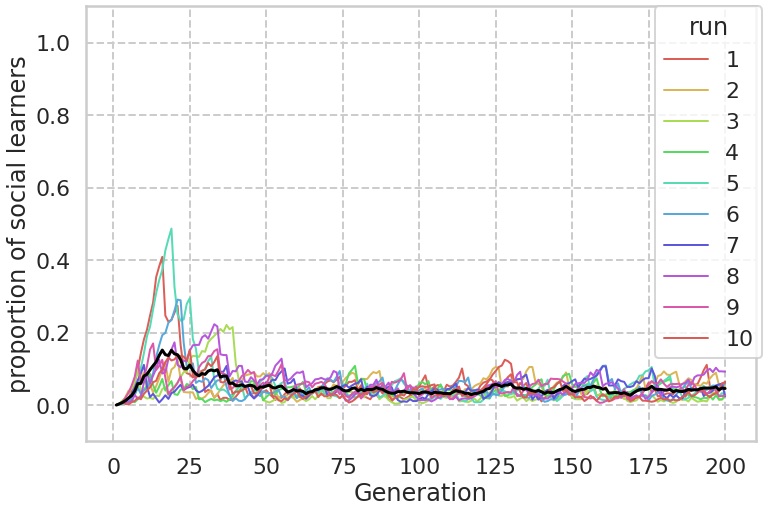

In [4]:
plot_multiple_runs_p_SL(data_model=data_model)

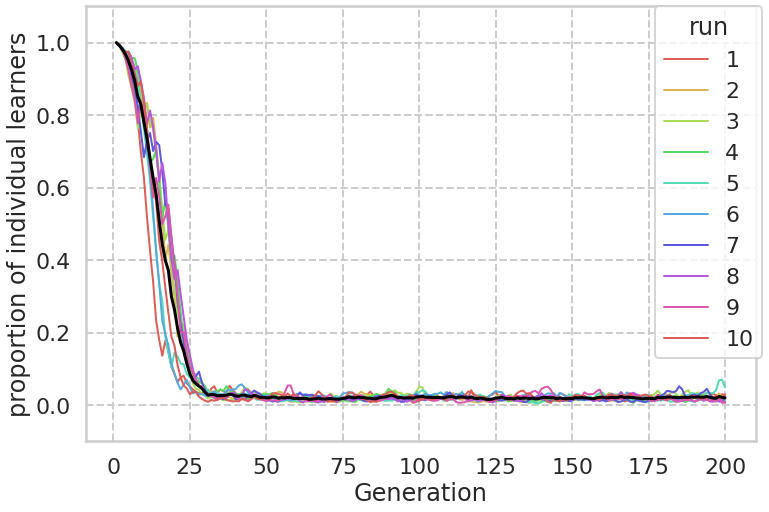

In [5]:
plot_multiple_runs_p_IL(data_model=data_model)

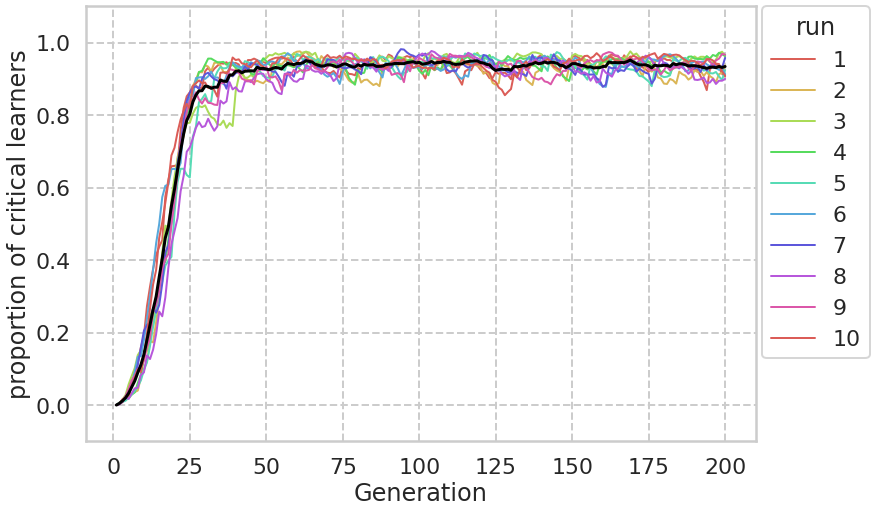

In [6]:
plot_multiple_runs_p_CL(data_model=data_model)

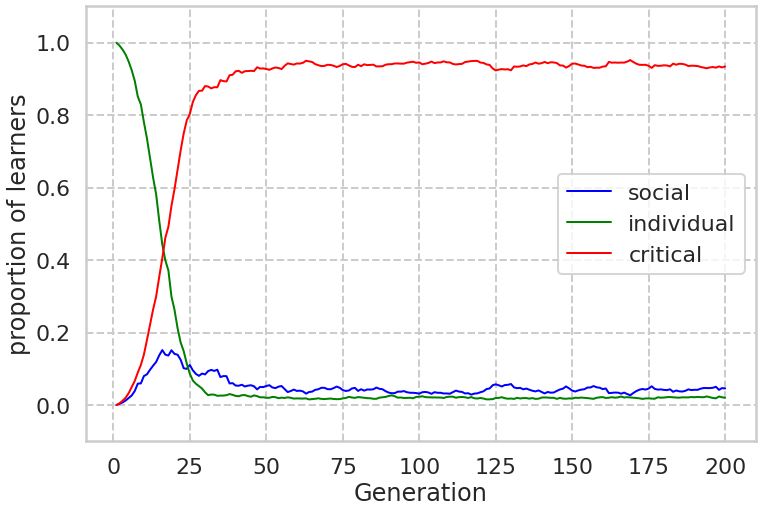

In [9]:
plot_multiple_runs_prop(data_model=data_model)

ここでは、クリティカルな学習者が他の２つの学習戦略よりも明らかに有利であることがわかります。批判的学習者は、突然変異を除いて、事実上固定化された状態になります。社会学習がうまくいかないときには、個人学習するような柔軟で分別の付く学習者がうまくいくのである。

ロジャーズのパラドックスはどうだろうか？クリティカルな学習者は、個人学習者だけで構成された集団の平均フィットネスを上回るのだろうか？それを知るには、前章の plot_W() 関数を使うことができます。

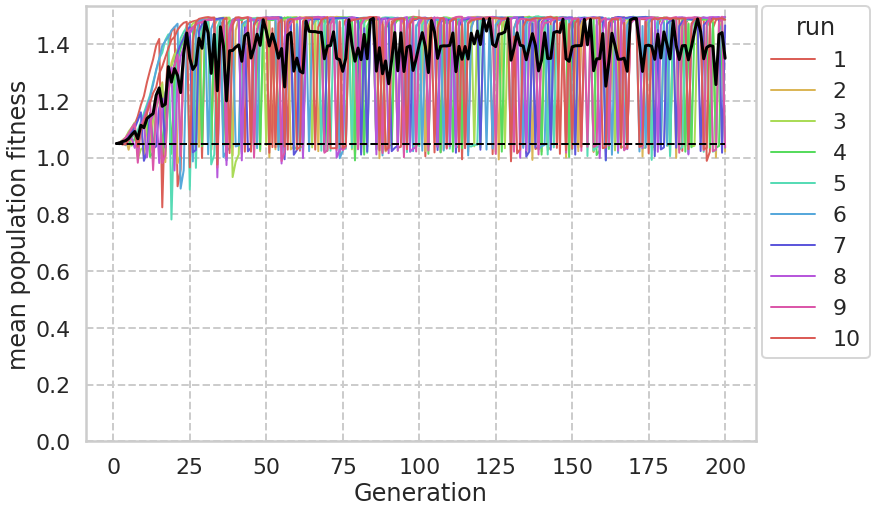

In [10]:
plot_W(data_model=data_model, c = 0.9, p = 1)

はい：多少のノイズが残っていても、仮に100%の個人学習者集団が存在すると仮定した場合、クリティカルな学習者の平均適応度の線が点線を明らかに上回っています。ロジャースのパラドックスは解決されました。

# **9.2　　モデルのまとめ**

ロジャースのパラドックスに対しては、いくつかの「解決策」が示されている。ここではそのうちの一つを探ってみた。クリティカルな学習者は、社会学習と個人学習の両方を柔軟に採用することができ、適応的な方法でこれを行うことができる（すなわち、社会学習が失敗した場合にのみ個人学習を行う）。クリティカルな学習者は、純粋な個人学習と純粋な社会学習の戦略を凌駕する。したがって、クリティカル学習者は、個人学習のみで構成された集団の平均適合度を超えることで、ロジャーズのパラドックスを解決しているのである。

これはすべて自明の理だと文句を言う人もいるかもしれない。もちろん、実際の生物は社会学習と個人学習の両方を行うことができ、生涯の間に適応的に両方を採用することができる。しかし、後知恵とは素晴らしいものである。ロジャースのモデル以前は、学者たちはこのことを十分に認識しておらず、社会学習は個人学習よりもコストが低いので適応的であると単純に主張していた。今では、この主張が誤りであることがわかっている。しかし、それに気付き、その理由に気付くためには、単純なモデルが必要だったのである。

# **9.3　　さらに学びたい人のために**

ロジャーズのパラドックスに対する解決策は他にもいくつかある。Boyd and Richerson（1995）は、最初は個人学習し、満足できなければ社会学習する個人を提案している。BoydとRicherson（1995）はまた、文化が累積的であれば、すなわち、各世代が前の世代の有益な修正の上に構築されれば、ロジャースのパラドックスが解決される可能性を示唆した。